# "The Battle of the Neighborhoods"
### Applied Data Science Capstone Project
<hr>

## Table of contents
* [Introduction/Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

<hr>

# Introduction/Business Problem <a name="introduction"></a>

##### Purpose
This project aims to identify and prioritize improvement opportunities for neighborhood parks in Green Bay, Wisconsin, USA.
##### Audience
The target audience for this analysis is a community action group working toward improved elementary education outcomes for the city population. The group includes representation from the school district, local government, business community leaders, and citizen stakeholders. The group wants to know if they should pursue a park improvement initiative.
##### Background
Successful school outcomes are the result of a complex system of factors. Many factors are within a school's control, such as student-to-teacher ratio or highly qualified teachers. Many more factors, however, are outside a school's control, such as parent engagement, neighborhood safety, and food security. To effectively address this complex issue, a complex solution is required, with interventions applied to internal and external factors concurrently. It is unrealistic to expect a school district to create meaningful and lasting improvements to student outcomes without outside assistance addressing external factors.
The external factor examined by this analysis is equitable access to outdoor recreational activities provided by public parks. The greenspaces and playgrounds found in public parks promote the holistic development of healthy children through physical activity, environment exploration, and unstructured, self-directed play.

### Objective 1: Proof of Principle
Based on observations made from the data, is this idea worth pursuing? The primary purpose of this analysis is to **determine whether or not to pursue a park improvement initiative.** In other words, is there any measurable relationship between school outcomes and access to parks.
* Hypothesis 1: Quantity of nearby parks is related to higher school performance.
* Hypothesis 2: Size of nearby parks is related to higher school performance.
* Hypothesis 3: Specific park amenities are related to higher school performance.

### Objective 2: Identify Recommendations for Action

If the determination is made to pursue the initiative, which park improvements should be prioritized?
* **Which neighborhoods** are in need of park improvement/development?
* **What specific improvements** might provide the most benefit to park users?
<hr>

# Data <a name="data"></a>

To understand the current state of elementary schools in Green Bay, the following data will be pulled from the Wisconsin Department of Public Instruction ("DPI") website:
* **Names and locations of elementary schools** in the Green Bay Area Public School District ("GBAPS").
* **School accountability reports** from the last seven years. These reports include a variety of performance metrics. The data will be used to select neighborhoods in greatest need of intervention. This data can also be used as a target for machine learning models seeking to explain factors related to school performance.

To understand the current state of parks in Green Bay, the following data will be retrieved from the Foursquare API.
* **Names and locations of parks** in the proximity of elementary schools. Park distance from school will be a feature considered for modeling.
* **User ratings of parks.** This will serve as a metric of park quality, another feature to be considered for modeling.


## School Data
#### Names and locations
First I'll grab the names and locations of schools. This data is easily acquired by downloading a CSV from the DPI public data portal. Let's load the CSV into a dataframe and clean it up.

In [63]:
import pandas as pd
import numpy as np

import re
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
schools = pd.read_csv('school_list.csv')
schools.columns

Index(['X', 'Y', 'FID', 'SCHOOL', 'DISTRICT', 'SCH_TYPE', 'LOW_GRADE',
       'HIGH_GRADE', 'TYPE_DESC', 'SCH_CAT', 'CHARTER', 'VIRTUAL', 'FULL_ADDR',
       'Unnamed: 13', 'STAND_ADDR', 'PHYS_COUNT', 'CESA', 'DIST_CODE',
       'SCH_CODE', 'UNIQUE_', 'NCES_DIST', 'NCES_SCH', 'ASM', 'SEN', 'CON',
       'Latitude', 'Longitude'],
      dtype='object')

Let's filter out the data we won't use. First, unused columns will be dropped so the dataframe is easier to look at. We will keep the columns related to school name, type, grade level, address, and geocoordinates. Second, we'll focus on dropping rows that do not contain elementary schools.

In [8]:
# Drop the columns that will not be used
schools.drop(['X','Y','FID','DISTRICT','TYPE_DESC','SCH_CAT','CHARTER','VIRTUAL','FULL_ADDR','PHYS_COUNT','CESA','DIST_CODE','SCH_CODE','UNIQUE_','NCES_DIST','NCES_SCH','ASM','SEN','CON'], axis=1, inplace=True)

# Rename remaining columns
schools.rename(columns={'SCHOOL':'SchoolName','SCH_TYPE':'SchoolType','LOW_GRADE':'LowGrade','HIGH_GRADE':'HighGrade','STAND_ADDR':'SchoolAddress'}, inplace=True)

# Since we're focusing on elementary schools, keep rows with a starting grade of 'K' and an ending grade of 5 or 8.
# Note, K-8 schools are technically not considered elementary schools. I'll probably end up dropping them, but want to see the data first.
#schools = schools[schools.LowGrade.str.contains('K')]
#schools = schools[(schools.HighGrade.str.contains('5') | schools.HighGrade.str.contains('8'))]

# Since we're focusing on elementary schools, only school names contained 'El' for elementary will be kept.
schools.drop(schools.index[schools.SchoolName.str.contains('El')==False], axis=0, inplace=True)

# Sort dataframe by school name and reset index
schools = schools.sort_values('SchoolName')
schools.reset_index(inplace=True, drop=True)

# Now that the dataframe only contains elementary schools, we can drop the SchoolType variable and remove 'El' from the school names
schools.drop(['SchoolType','Unnamed: 13'], axis=1, inplace=True)
for i in range(0,len(schools.SchoolName)):
    schools.at[i,'SchoolName'] = schools.at[i,'SchoolName'].replace(' El','')

In [9]:
print(f'The dataframe has {schools.shape[0]} rows and {schools.shape[1]} columns.')
schools.head()

The dataframe has 25 rows and 6 columns.


,SchoolName,LowGrade,HighGrade,SchoolAddress,Latitude,Longitude
0,Baird,K4,5,"539 Laverne Dr Green Bay, WI 54311-5720",44.510968,-87.933378
1,Beaumont,K4,5,"1505 Gatewood St Green Bay, WI 54304-3375",44.505500,-88.051171
2,Chappell,K4,5,"205 N Fisk St Green Bay, WI 54303-3199",44.530298,-88.054852
3,Danz,K4,5,"2130 Basten St Green Bay, WI 54302-5398",44.508833,-87.968792
4,Doty,K4,5,"525 Longview Ave Green Bay, WI 54301-1199",44.453509,-88.030442


#### School accountability scores
The next piece of school data we need are performance metrics, which the DPI reports annually in School Report Cards. After much searching through the DPI data portal, I could only find report cards shared in PDF format. I bulk-downloaded all the PDFs and scraped them to populate a dataframe using two libraries: os and pdfminer. I may share this process in a separate notebook, but for the purpose of this analysis I'm only going to import the output.

*Note, the DPI did not publish school report cards for the 2014-2015 school year*

In [10]:
school_scores = pd.read_csv('school_report_cards.csv')
print(f'The dataframe has {school_scores.shape[0]} rows and {school_scores.shape[1]} columns.')
school_scores.head()

The dataframe has 193 rows and 7 columns.


,School,Year,Overall Score,Student Achievement,Student Growth,Closing Gaps,On-Track and Postsecondary Readiness
0,Aldo Leopold,2011-12,74.5,71.5,74.1,63.5,89.0
1,Aldo Leopold,2012-13,75.3,72.6,69.6,68.3,90.6
2,Aldo Leopold,2013-14,77.3,72.1,71.7,75.6,89.9
3,Aldo Leopold,2015-16,66.0,70.6,37.5,66.5,89.0
4,Aldo Leopold,2016-17,70.3,66.3,61.3,64.8,88.0


After looking through the year-to-year trends for several schools, I see a school's overall score can change quite a bit. I will use the mean of a school's overall scores for the purpose of comparing schools.

In [11]:
avg_scores=[]

# Loop through the list of schools, get average of yearly Overall Scores, add the average score to the 'schools' dataframe
for school in list(schools.SchoolName.unique()):
    average_score = school_scores['Overall Score'][school_scores['School']==school].mean()
    avg_scores.append(average_score)

schools['AvgOverallScore'] = avg_scores

In [12]:
import folium, geocoder
import matplotlib.cm as cm
import matplotlib.colors as colors

In [13]:
def coordinates(address):
    coords = None
    while (coords is None):
        g = geocoder.arcgis(address)
        coords = g.latlng   
    return coords

Let's plot the schools on a map, applying a gradient color coding. The highest performing schools will plotted in green and the lowest performing schools will be plotted in red.

In [14]:
schools = schools.sort_values('AvgOverallScore')

num_splits = schools.shape[0]*2
x = np.arange(num_splits)
ys = [i + x + (i*x)**2 for i in range(num_splits)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
hex_colors_array = [colors.rgb2hex(i) for i in colors_array]

schools['MarkerColor'] = hex_colors_array[0:schools.shape[0]]

map = folium.Map(location=coordinates('Green Bay, WI'), zoom_start=12, tiles='Stamen Toner')
for i,row in schools.iterrows():
    folium.CircleMarker((row['Latitude'],row['Longitude']),
                         radius=15,
                         color=row['MarkerColor'],
                         fill=True,
                         alpha=1,
                        popup=str(row['SchoolName']+': '+str(round(row['AvgOverallScore'],1)))).add_to(map)
map

Upon visual inspection, there appears to be a trend of decreasing scores for schools closer to the center of the city. In addition, poverty levels and crime rates tend to rise in neighborhoods closer to the center of the city. These two factors likely have an impact on students' school performance.

## Park Data
#### Names, Locations and Ratings
First, we'll use the Foursquare API to locate parks in the vicinity of each school. The following functions will be created to perform this task:
* Use Foursquare API to find venues near each school matching search term "Park"
* Use Foursquare API to confirm venue category is a park, and does not just have "Park" in the name
* Calculate distance between park and school
* Use Foursquare API to get rating of park


In [15]:
# Import libraries for this step
import requests
from pandas.io.json import json_normalize
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [16]:
# Define API credentials
CLIENT_ID = # deleted for sharing notebook
CLIENT_SECRET = # deleted for sharing notebook
VERSION = '20180604'

I'll borrow this function from the previous lab to get venue categories.

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
# This line of code will stop displaying a warning message I was getting
pd.options.mode.chained_assignment = None  # default='warn'

This function will calculate distance between parks and schools.

In [19]:
# function that finds distance between two points on a sphere
# function adapted from scikit-learn documentation

def calculate_distance(loc1,loc2):
    loc1_in_radians = [radians(_) for _ in loc1]
    loc2_in_radians = [radians(_) for _ in loc2]
    result = haversine_distances([loc1_in_radians, loc2_in_radians])[1][0]
    
    return result * 6371000  # multiply by Earth radius to get meters

This function will look up park rating.

In [20]:
# function that gets rating from venue details

def get_rating(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        rating = result['response']['venue']['rating']
    except:
        rating = 'no rating'
    return rating

This function will look up parks and put them into a dataframe.

In [21]:
def get_parks(df,index):
    search_query = 'Park'
    radius = 1000
    LIMIT=20
    lat,lng = list(df.loc[index][['Latitude','Longitude']])
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
    school = df.loc[index]['SchoolName']

    # send the GET request
    results = requests.get(url).json()
    
    venues = results['response']['venues']
        
    nearby_parks = json_normalize(venues) # flatten JSON
    
    # filter columns
    filtered_columns = ['id','name', 'categories', 'location.lat', 'location.lng']
    #nearby_parks =nearby_parks.loc[:, filtered_columns]
    try:
        nearby_parks = nearby_parks[filtered_columns]
    except:
        print(f'0 parks found near {school}.')
        return None

    # filter the category for each row
    nearby_parks['categories'] = nearby_parks.apply(get_category_type, axis=1)
    
    # clean columns
    #nearby_parks.columns = [col.split(".")[-1] for col in nearby_parks.columns]
    
    # remove venues that are not parks
    nearby_parks = nearby_parks[nearby_parks['categories']=='Park']
    
    print(f'{nearby_parks.shape[0]} parks found near {school}.')

    nearby_parks['NearSchool'] = school
    nearby_parks['Distance'] = 0
    nearby_parks['Rating'] = 0
    for i,row in nearby_parks.iterrows():
        nearby_parks.at[[i],['Distance']] = calculate_distance([lat,lng], [nearby_parks.loc[i]['location.lat'],nearby_parks.loc[i]['location.lng']])
        nearby_parks.at[[i],['Rating']] = get_rating(nearby_parks.loc[i]['id'])
    

    return nearby_parks

Now that all the functions are defined, we can run through the list of schools and search for parks.

In [22]:
parks = pd.DataFrame(columns=['id','name','categories','location.lat','location.lng','NearSchool','Distance','Rating'])
for row in schools.index:
    df = get_parks(schools,row)
    parks = parks.append(df)

7 parks found near Howe.
1 parks found near Eisenhower.
5 parks found near Nicolet.
5 parks found near Sullivan.
3 parks found near Jefferson.
1 parks found near Danz.
6 parks found near Fort Howard.
0 parks found near Lincoln.
1 parks found near Elmore.
2 parks found near Keller.
0 parks found near Doty.
2 parks found near Chappell.
1 parks found near Martin.
2 parks found near Baird.
1 parks found near Beaumont.
2 parks found near Tank.
3 parks found near Jackson.
0 parks found near King.
1 parks found near Wilder.
2 parks found near Webster.
4 parks found near Kennedy.
1 parks found near Langlade.
0 parks found near Wequiock.
2 parks found near MacArthur.
1 parks found near McAuliffe.


I'm going to edit the column names so that I have a consistent style throughout all dataframes.

In [23]:
parks.rename(columns={'id':'ParkId','categories':'Category','name':'ParkName','location.lat':'ParkLatitude','location.lng':'ParkLongitude'}, inplace=True)
parks.reset_index(drop=True, inplace=True)

Interesting, there appear to be lots of parks near the low-scoring schools, such as Howe, Nicolet and Sullivan. Let's inspect the park data to look for other trends.

In [24]:
parks.describe(include='all')

,ParkId,ParkName,Category,ParkLatitude,ParkLongitude,NearSchool,Distance,Rating
count,53,53,53,53.000000,53.000000,53,53.000000,53
unique,39,38,1,NaN,NaN,21,NaN,7
top,5016dddee4b0c3d592c0acb0,John Muir Park,Park,NaN,NaN,Howe,NaN,no rating
freq,3,4,53,NaN,NaN,7,NaN,46
mean,NaN,NaN,NaN,44.510109,-88.018203,NaN,704.104393,NaN
std,NaN,NaN,NaN,0.015584,0.038214,NaN,352.888846,NaN
min,NaN,NaN,NaN,44.461471,-88.087044,NaN,64.233380,NaN
25%,NaN,NaN,NaN,44.502340,-88.050848,NaN,442.216296,NaN
50%,NaN,NaN,NaN,44.510584,-88.017159,NaN,732.769761,NaN
75%,NaN,NaN,NaN,44.519090,-87.995321,NaN,1000.347448,NaN


I see a few things that will need to be cleaned up during the next week. 
* There are more IDs than Names, probably meaning some parks are duplicated in the Foursquare database. Duplicates will need to be removed
* Howe, the lowest scoring school, has the most parks. Will this still be true once duplicates are removed?
* 46 parks do not have a rating. This feature won't work for modeling.

Since most parks are not rated, I'll need to look elsewhere for data describing park characteristics. The Green Bay Department of Parks, Recreation and Forestry website will have more information. To keep this notebook from getting too long, I'll create a separate notebook to write a function using BeautifulSoup to scrape the website, and upload the results into this notebook.

In [25]:
parks = pd.read_csv('parks_scrape_2.csv')

In [26]:
# This unnamed column can be dropped. It was the index of the dataframe that I exported to a csv
parks.drop(['Unnamed: 0'],axis=1, inplace=True)

In [27]:
# These columns are left over from scraping and not needed, so I'll drop them too
parks.drop(['ParkURL','ParkAddress'], axis=1, inplace=True)

Here is the map again with schools color-coded according to performance scores. This time parks are also included, represented by small purple dots.

In [28]:
map = folium.Map(location=coordinates('Green Bay, WI'), zoom_start=12, tiles='Stamen Toner')
for i,row in schools.iterrows():
    folium.CircleMarker((row['Latitude'],row['Longitude']),
                         radius=15,
                         color=row['MarkerColor'],
                         fill=True,
                         alpha=1,
                        popup=str(row['SchoolName']+': '+str(round(row['AvgOverallScore'],1)))).add_to(map)
for i,row in parks.iterrows():
    folium.CircleMarker((row['ParkLatitude'],row['ParkLongitude']),
                        radius=5,
                        color='purple',
                        fill=True,
                        alpha=1,
                        popup=str('Park: '+row['ParkName']+' / Acreage: '+str(row['ParkAcreage']))).add_to(map)
map

There are just a few more steps I want to complete before I begin selecting features for modeling. First, I'm going to calculate the distance between all parks and all schools, just to be sure all parks within one kilometer are included.

In [29]:
for i,row in parks.iterrows():
    park_loc = row[['ParkLatitude','ParkLongitude']]
    park = row['ParkName']
    for ii,rrow in schools.iterrows():
        school = rrow['SchoolName']
        school_loc = rrow[['Latitude','Longitude']]
        dist = calculate_distance(park_loc,school_loc)
        parks.at[i,school]=dist

From the Department of Parks and Rec website I was able to learn which amenities are available at each park. Below is a plot of the total number of each type of park amenity. *(Note: some parks have multiple instances of an amenity.)*

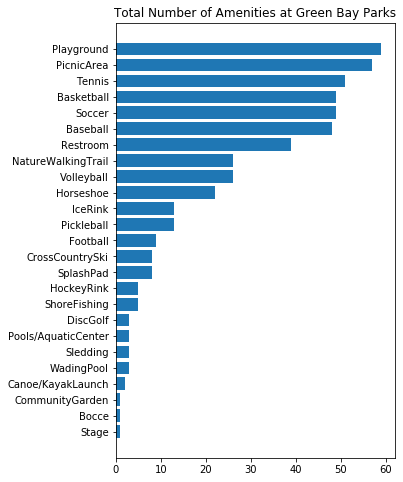

In [46]:
amenities = list(parks.columns[4:29])
amenity_count = parks[amenities].sum().sort_values()
plt.figure(figsize=(5,8))
plt.barh(amenity_count.index,amenity_count)
plt.title('Total Number of Amenities at Green Bay Parks')
plt.show()

### At last!
I have all the data I need to perform some analysis. Using the "parks" dataframe, I'll add the following features to the "schools" dataframe:
* Total number of parks within 1 kilometer of school
* Total park acreage within 1 kilometer of school
* Average acreage per park with 1 kilometer of school
* Average distance from school to parks within 1 kilometer of school
* Total number of each amenity within 1 kilometer of school

In [32]:
# First, I'll drop a few more columns that are no longer needed.
schools.drop(['LowGrade','HighGrade','SchoolAddress'], axis=1, inplace=True)

In [47]:
for i,row in schools.iterrows():
    school = row['SchoolName']
    schools.at[i, 'NearbyParks'] = parks['ParkName'][parks[school]<1000].count()
    schools.at[i, 'TotalNearbyAcreage'] = parks['ParkAcreage'][parks[school]<1000].sum()
    schools.at[i, 'AvgNearbyAcreage'] = parks['ParkAcreage'][parks[school]<1000].mean()
    schools.at[i, 'AvgNearbyParkDistance'] = parks[school][parks[school]<1000].mean()
    for amenity in amenities:
        schools.at[i, amenity] = parks[amenity][parks[school]<1000].sum()

In [191]:
#for column in schools.columns:
 #   schools[column] = np.nan_to_num(schools[column])

In [49]:
schools.iloc[:,3:schools.shape[1]].describe()

,AvgOverallScore,NearbyParks,TotalNearbyAcreage,AvgNearbyAcreage,AvgNearbyParkDistance,Basketball,NatureWalkingTrail,PicnicArea,Playground,Soccer,...,Sledding,WadingPool,HockeyRink,CommunityGarden,Canoe/KayakLaunch,Baseball,Bocce,ShoreFishing,DiscGolf,Stage
count,25.000000,25.000000,25.000000,24.000000,24.000000,25.000000,25.000000,25.000000,25.000000,25.000000,...,25.000000,25.000000,25.000000,25.00,25.00,25.000000,25.00,25.000000,25.00,25.00
mean,67.314857,2.320000,30.666800,17.060951,533.369118,1.840000,0.720000,2.080000,2.120000,1.240000,...,0.120000,0.080000,0.120000,0.04,0.04,1.800000,0.04,0.080000,0.04,0.04
std,7.059267,1.676305,23.610393,14.323788,197.348611,1.312758,0.979796,1.497776,1.363818,1.640122,...,0.331662,0.276887,0.331662,0.20,0.20,1.779513,0.20,0.276887,0.20,0.20
min,53.614286,0.000000,0.000000,2.241667,137.628556,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00
25%,64.985714,1.000000,14.140000,7.512500,439.129045,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.00,1.000000,0.00,0.000000,0.00,0.00
50%,67.914286,2.000000,21.080000,13.970000,504.379998,2.000000,1.000000,2.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.00,0.00,1.000000,0.00,0.000000,0.00,0.00
75%,70.842857,3.000000,39.170000,20.186500,670.985242,2.000000,1.000000,3.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,0.00,0.00,2.000000,0.00,0.000000,0.00,0.00
max,81.585714,6.000000,98.560000,60.480000,965.207681,6.000000,4.000000,5.000000,6.000000,7.000000,...,1.000000,1.000000,1.000000,1.00,1.00,6.000000,1.00,1.000000,1.00,1.00


<hr>

# Methodology <a name="methodology"></a>

I will use Multiple Linear Regression to test the impact features have on school performance scores.

First I need to select features for modeling. I need to find features that are individually correlated to the target variable, but not too strongly correlated with each other. (If there are multiple features that are strongly correlated to the target and each other, it might be appropriate to create a composite variable.)


Let's check out a couple features with scatter plots. One hypothesis I have, based on the maps above, is a "quality over quantity" sort of dynamic exists. I'm guessing there will be a negative correlation between school performance and number of parks, and a positive correlation between school performance and average nearby acreage.

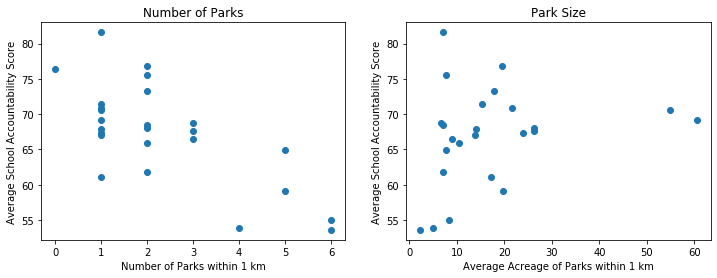

In [193]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(schools.NearbyParks, schools_2.AvgOverallScore)
plt.xlabel("Number of Parks within 1 km")
plt.ylabel("Average School Accountability Score")
plt.title('Number of Parks')

plt.subplot(122)
plt.scatter(schools.AvgNearbyAcreage, schools_2.AvgOverallScore)
plt.xlabel("Average Acreage of Parks within 1 km")
plt.ylabel("Average School Accountability Score")
plt.title('Park Size')
plt.show()

There is definitely a negative correlation with the number of parks, but park size does not seem to be significantly correlated.

Let's see which other features are correlated to school performance.

In [59]:
# Create a correlattion table including every column of the dataframe (expect school name, latitude, and longitude)
correlation_table = schools.iloc[:,3:schools.shape[1]].corr()

# Remove the first row, which is school performance scores
correlation_table.drop('AvgOverallScore', axis=0, inplace=True)

# Focus on correlations to the target variable
correlations = correlation_table['AvgOverallScore']

# Add all variables with a correlation greater than 0.3 or less than -0.3 to a list
features = correlations.index[abs(correlations)>0.3].to_list()

# Print the results
print('Potentially significant positive correlations:')
print(correlations[correlations>0.3])
print('----------------------------------------------')
print('Potentially significant negative correlations:')
print(correlations[correlations<-0.3])


Potentially significant positive correlations:
Sledding    0.350813
Name: AvgOverallScore, dtype: float64
----------------------------------------------
Potentially significant negative correlations:
NearbyParks           -0.707351
Basketball            -0.486927
NatureWalkingTrail    -0.314951
PicnicArea            -0.730287
Playground            -0.655987
Horseshoe             -0.611832
Restroom              -0.457380
Volleyball            -0.441440
Pools/AquaticCenter   -0.301798
Stage                 -0.404332
Name: AvgOverallScore, dtype: float64


Now that I have a list of potential features, I'll run a new correlation table to look for collinearity.

In [61]:
schools[features].corr()

,NearbyParks,Basketball,NatureWalkingTrail,PicnicArea,Playground,Horseshoe,Restroom,Volleyball,Pools/AquaticCenter,Sledding,Stage
NearbyParks,1.000000,0.743742,0.538833,0.968510,0.839101,0.753249,0.728086,0.512125,0.328780,-0.146891,0.457355
Basketball,0.743742,1.000000,0.320056,0.748476,0.918808,0.809693,0.721006,0.484799,0.373182,-0.049764,0.025392
NatureWalkingTrail,0.538833,0.320056,1.000000,0.555361,0.431552,0.487818,0.248350,-0.165928,0.250000,-0.020515,0.059536
PicnicArea,0.968510,0.748476,0.555361,1.000000,0.851816,0.776353,0.707416,0.532133,0.381597,-0.187886,0.406158
Playground,0.839101,0.918808,0.431552,0.851816,1.000000,0.853917,0.761446,0.549511,0.329276,-0.125278,0.134427
Horseshoe,0.753249,0.809693,0.487818,0.776353,0.853917,1.000000,0.740140,0.581302,0.349482,-0.118300,0.008917
Restroom,0.728086,0.721006,0.248350,0.707416,0.761446,0.740140,1.000000,0.708842,0.211195,-0.046216,0.134120
Volleyball,0.512125,0.484799,-0.165928,0.532133,0.549511,0.581302,0.708842,1.000000,0.145693,0.017934,0.257742
Pools/AquaticCenter,0.328780,0.373182,0.250000,0.381597,0.329276,0.349482,0.211195,0.145693,1.000000,-0.184637,-0.102062
Sledding,-0.146891,-0.049764,-0.020515,-0.187886,-0.125278,-0.118300,-0.046216,0.017934,-0.184637,1.000000,-0.075378


Multicollinearity exists in several of these features. Many of these variables are strongly correlated with NearbyParks (Basketball, NatureWalkingTrail, PicnicArea, Playground, Horseshoe, Restroom, Volleyball). This makes sense, they are the most common park amenities and are found at most parks. Since they are found at most parks, I will keep the NearbyParks variable but remove the others from consideration.

That leaves a few more to consider: Pools, Sledding, and Stage. Let's inspect each of these with scatter plots.

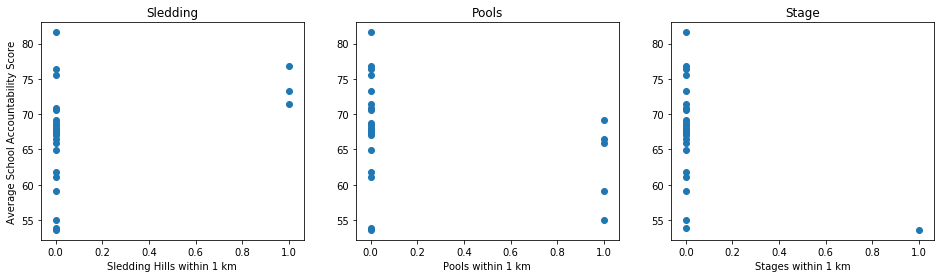

In [62]:
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.scatter(schools.Sledding, schools.AvgOverallScore)
plt.xlabel("Sledding Hills within 1 km")
plt.ylabel("Average School Accountability Score")
plt.title('Sledding')

plt.subplot(132)
plt.scatter(schools['Pools/AquaticCenter'], schools.AvgOverallScore)
plt.xlabel("Pools within 1 km")
plt.title('Pools')

plt.subplot(133)
plt.scatter(schools.Stage, schools.AvgOverallScore)
plt.xlabel("Stages within 1 km")
plt.title('Stage')
plt.show()

Since there is only one instance of Stage, it doesn't make sense to keep that as a feature, but I'll keep the other two. 

My final list of features for modeling are:
* Total number of nearby parks
* Nearby sledding hills
* Nearby pools or aquatic centers

Now I will perform linear regression to see how the features interact with the target variable. My objective, at this point, is simply to measure what relationship may exist. I'm not trying to predict school performance scores, so I will not split the data into training and testing sets. However, if I had a larger training set, I probably would split it.

In [209]:

from sklearn import linear_model
LR = linear_model.LinearRegression()
x = schools[['NearbyParks','Sledding','Pools/AquaticCenter']]
y = schools['AvgOverallScore']
LR.fit(x,y)
print('Coefficients: ', LR.coef_)
print('Intercept: ', LR.intercept_)


Coefficients:  [-2.77089213  5.25290299 -0.68993161]
Intercept:  73.25096484470416


So, sklearn is actually pretty limited in it's output. I get the coefficients and intercept, but for my purpose what I'm really interested in are the p values for each feature. I'll run the regression again using statsmodels. It should return the same coefficients as sklearn, but will also let me see if the features' contributions to the model are statistically significant.

In [64]:
import statsmodels.api as sm

In [211]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

C:\Users\dritter\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:        AvgOverallScore   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     9.057
Date:                Sat, 25 Jul 2020   Prob (F-statistic):           0.000481
Time:                        19:32:35   Log-Likelihood:                -73.444
No. Observations:                  25   AIC:                             154.9
Df Residuals:                      21   BIC:                             159.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  73.2510    

#### Unfortunately, it looks like the only significant feature is Nearby Parks.
<hr>

# Results <a name="results"></a>

### Hypothesis 1: Access to parks is related to higher school performance.

#### **Result:** Not Supported

In fact, a significant *negative* correlation exists between the number of nearby parks and school performance. In other words, low-performing schools tend to have more parks nearby. This appears to be due in part to the high density of very small parks located in the city center, where lower-performing schools also tend to be located.


### Hypothesis 2: The size of parks, not the quantity, is related to higher school performance.

#### **Result:** Not Supported

There was no significant correlation between the two variables. Small and mid-sized parks were equally likely to be near low- or high-performing schools. The largest parks tended to be around average-performing schools.


### Hypothesis 3: Specific park amenities are related to higher school performance.

#### **Result:** Not Supported

Many common park amenities, such as playgrounds or basketball courts, are so prevalent that there is not a meaningful difference between the parks themselves and individual park amenities. Are few excpetions are Sledding Hills and Pools/Aquatic Centers, which were both positively correlated with higher school performance, but not significantly.

<hr>

# Discussion <a name="discussion"></a>


### Recommendation 1: Data Development Agenda
It is recommended that the City of Green Bay collect, store, and make publicly-available detailed information on its Parks, Recreation and Forestry holdings and assets. This would include an assessment of park amenities, date of last improvement, planned future improvements, cost of amenities.

It is unfortunate that Foursquare had insufficient rating data for Green Bay parks, because a measure of park quality is major gap in this analysis. Schools in dense urban areas are clearly nearby several parks, but the current state of those parks is not accounted for. Playgrounds which are old, outdated, or in disrepair could potentially have an adverse impact on neighborhood kids. Furthermore, more detailed and publicly-available on parks would be helpful in determining the impact of parks on the communities they are in. Such data would allow us to examine what impacts are observed immediately following park improvements. Do school performance scores rise? Does crime decrease?

### Recommendation 2: Focus on Winter Activities
Continue to investigate the impact of sledding hills.

Although sledding hills ended up not passing the test for statistical significance, it was close. In Green Bay, snow may be on the ground for 4-6 months each year. This has a major impact on access to park amenities. Most publicly-available, outdoor, winter activites require expensive equipment, such as cross-country skiiing, hockey, or ice skating. Sledding is unique in its accessibility to a wider range of socioeconomic levels. Furthermore, if parks are to have an impact on school performance, it seems important that meaningful park amenities would be available when school is actually in session (the winter).

### Other questions...
#### How does this park data compare to other school or community factors?
I found two more variables that might have a significant impact on school performance: Student/Teacher Ratio, and Median Income of families in neighborhood around each school. Below are the scatter plots and regression results for these two variables.


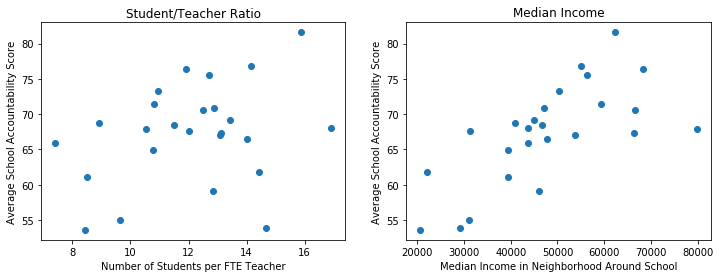

In [229]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(schools.StudentTeacherRatio, schools.AvgOverallScore)
plt.xlabel("Number of Students per FTE Teacher")
plt.ylabel("Average School Accountability Score")
plt.title('Student/Teacher Ratio')

plt.subplot(122)
plt.scatter(schools.MedianIncome, schools.AvgOverallScore)
plt.xlabel("Median Income in Neighborhood Around School")
plt.ylabel("Average School Accountability Score")
plt.title('Median Income')
plt.show()

In [230]:
x = schools[['MedianIncome','Sledding','StudentTeacherRatio']]
y = schools['AvgOverallScore']
LR.fit(x,y)
print('Coefficients: ', LR.coef_)
print('Intercept: ', LR.intercept_)

Coefficients:  [2.92010010e-04 5.16144852e+00 6.73448159e-01]
Intercept:  44.63712114074613


In [231]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

C:\Users\dritter\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:        AvgOverallScore   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     9.448
Date:                Wed, 29 Jul 2020   Prob (F-statistic):           0.000376
Time:                        08:16:39   Log-Likelihood:                -73.143
No. Observations:                  25   AIC:                             154.3
Df Residuals:                      21   BIC:                             159.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  44.6371    

### Results:
Median Income is definitely a significant factor, but Student/Teacher Ratio is actually (slightly) less significant than nearby Sledding Hills. Perhaps more reason to give more consideration to accessible winter activities.
<hr>

# Conclusion <a name="conclusion"></a>

### Objective 1: Proof of Principle = Rejected
At this time, it is the recommendation of this analysis that the community action group not pursue a park improvement initiative as a targeted means of improving school performance. Instead, it is recommended the group pursue impacts related to Median Income level. Questions to consider in future analysis include:
* Is this the right data to answer this question? Incorporating time-based data may be more appropriate.
* Is the Overall School Accountability Score an accurate measure of school performance? Does it represent child well-being in a meaningful way?
* What would be a more meaningful metric to represent the well-being of neighborhood children?

## Thank you for taking the time to review this analysis!